# Top

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from functools import reduce
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import metrics #For accuracy calculation
%config InlineBackend.figure_format = 'retina'

# Data Cuts & Processing

In [150]:
dat = Table.read(r"Data\s5_dr3.1_xdes_dr2.fits", format='fits') #Import S5 x DES data
df = dat.to_pandas()

# Generate colors
df['decam_(g-r)'] = df["wavg_mag_psf_g_dered"] - df["wavg_mag_psf_r_dered"]
df['decam_(r-z)'] = df["wavg_mag_psf_r_dered"] - df["wavg_mag_psf_z_dered"]
df['decam_(r-i)'] = df["wavg_mag_psf_r_dered"] - df["wavg_mag_psf_i_dered"]
df['decam_(r-y)'] = df["wavg_mag_psf_r_dered"] - df["wavg_mag_psf_y_dered"] #Legacy: y photometry is unused

### Photometry cuts
g_minus_r_mask = df.index[df['decam_(g-r)'].between(0.35,0.8)].tolist()
r_minus_z_mask= df.index[df['decam_(r-z)'].between(0,0.5)].tolist()
r_minus_i_mask= df.index[df['decam_(r-i)'].between(0,0.3)].tolist()
r_mask= df.index[df['wavg_mag_psf_r_dered'].between(14,25)].tolist()
g_mask= df.index[df['wavg_mag_psf_g_dered'].between(14,25)].tolist()
i_mask= df.index[df['wavg_mag_psf_i_dered'].between(14,25)].tolist()
z_mask= df.index[df['wavg_mag_psf_z_dered'].between(14,25)].tolist()

### Spectroscopy cuts
metallicity_mask = df.index[df['feh50'].between(-3.3,0.3)].tolist() #Design boundaries of S5 are [-4,0.5]. Very few stars are <-3
snr_mask = df.index[(df['best_sn_580v'] > 10) & (df["best_sn_1700d"] > 10)].tolist() #Signal to Noise
survey_mask = df.index[df["decam_phot_src_bits"] == 585].tolist() #Ensures the data is DES in all griz colors
metallicity_std_mask = df.index[df["feh_std"] < 0.1].tolist() #Important data cut
temp_mask = df.index[df['teff50'].between(4750,6250)].tolist()

### Gaia cuts
gaia_g_mask = df.index[df['phot_g_mean_mag'].between(12,25)].tolist()
gaia_bp_mask = df.index[df['phot_bp_mean_mag'].between(12,25)].tolist()
gaia_rp_mask = df.index[df['phot_rp_mean_mag'].between(12,25)].tolist()
gaia_parallax_mask = df.index[df['parallax'].between(-2,4)].tolist()  #Minimal cut -- just extracts a few outliers
gaia_pmra_mask = df.index[df['pmra'].between(-30,80)].tolist()  #Same reasoning as above
variability_mask = df.index[df['gaia_rr'] == False].tolist()    # Eliminate rr lyrae stars (interestingly, with time-domain
# photometry, some variable stars can have this technique applied. See Miller et al. 2015 ApJ, 798, 122).

# For cut details see excel doc
total_mask = reduce(np.intersect1d, (g_minus_r_mask,r_minus_z_mask,r_minus_i_mask,r_mask,g_mask,i_mask,
                                     z_mask,metallicity_mask,snr_mask,survey_mask,metallicity_std_mask,temp_mask,variability_mask,
                                     gaia_g_mask,gaia_bp_mask,gaia_rp_mask,gaia_parallax_mask))
pd.options.mode.chained_assignment = None  # default='warn'
print("Size of data cut:", np.shape(df)[0], ">", np.shape(total_mask)[0])
df = df.loc[total_mask]

# Currently unused (needed for Gaia):
import getDust #Function made by Professor Ting Li
df['AG'], df['Abp'], df['Arp'] = getDust.getDust(df['phot_g_mean_mag'], df['phot_bp_mean_mag'], df['phot_rp_mean_mag'], 0.86*df['ebv'])
df['phot_bp_mean_mag_dered'] = df['phot_bp_mean_mag']  - df['Abp']
df['phot_rp_mean_mag_dered'] = df['phot_rp_mean_mag']  - df['Arp']
df['phot_g_mean_mag_dered'] = df['phot_g_mean_mag']  - df['AG']

Size of data cut: 68180 > 8391


# Training the Model
There are a lot of things here that may require knowledge of ML. The essentials are:
- Split dataset into training and test set
- Scale the data
- Define the model
- Train the model
- Evaluate the model

Defining the model involves many parameters that can be altered to potentially improve performance. Most of these parameters have already been altered to minimise the root-mean-square error (rmse), a very common way to evaluate model performance. The sigmoid activation, Adam loss function, and the number of neurons and epochs can be altered. There is a massive amount of useful information and tutorials online to learn more about these things. That said, no alterations or knowledge of these things is needed for the model to perform

In [151]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam

#Constructing data
model_columns = ['decam_(g-r)','decam_(r-z)','decam_(r-i)','wavg_mag_psf_r_dered']
#Split data into training set (75%) and test set (25%)
train=df.sample(frac=0.75,random_state=6) #random state is a seed value -- alter to randomly change training/test set
test=df.drop(train.index) # test set = data set \ training set
X_train = train[model_columns].reset_index(drop=True)
X_test = test[model_columns].reset_index(drop=True)
y_train = train[['feh50']].reset_index(drop=True) # feh50 = metallicity (what we are returning -- hence the 'y' of our algorithm)
y_test = test[['feh50']].reset_index(drop=True)

# Scaling the Data
stdscal = StandardScaler() #Scaling data to mean=0 and std=1 (for better performance)
X_train_transformed = pd.DataFrame(stdscal.fit_transform(X_train), columns=model_columns) #Learn to scale on the training set
X_test_transformed = pd.DataFrame(stdscal.transform(X_test), columns=model_columns) #Apply the learned scale on test (important not to learn a new one on test)
n_features = X_train.shape[1] #In ML parlance, features = columns in data

# define ANN model
model = Sequential([
    Dense(64, activation='sigmoid', kernel_initializer='he_normal', input_shape=(n_features,)),
    Dense(128, activation='sigmoid', kernel_initializer='he_normal'),
    Dense(32, activation='sigmoid', kernel_initializer='he_normal'),
    Dense(16, activation='sigmoid', kernel_initializer='he_normal'),
    Dense(1, activation='linear')])

# compile the model
opt = Adam()
from keras import callbacks #Can early stop the model if it is no longer improving in training each epoch
earlystopping = callbacks.EarlyStopping(monitor ="loss", 
                                        mode ="min", patience = 15, 
                                        restore_best_weights = True)
model.compile(optimizer=opt, loss='mse')

# Fit the model to the training set
history = model.fit(X_train_transformed.values, y_train['feh50'], batch_size=32, epochs=125, verbose=0, callbacks =[earlystopping])
# evaluate the model
error = model.evaluate(X_test_transformed, y_test['feh50'], verbose=0) # Evaluate model performance on test
rmse = np.sqrt(error)
print('MSE: %.3f, RMSE: %.3f' % (error, np.sqrt(error)))
y_test['pred_feh'] = model.predict(X_test_transformed)

MSE: 0.060, RMSE: 0.246


## Nearest Neighbor
Notice the Nearest Neighbor (NN) cut is performed on the X_train and X_test set, no the standard scalar-transformed X_train_transformed. This is so that when we looking at distances in color-color space or others, we can examine the data directly in the units it is given in, rather than arbitrary mean=0/std=1 units.
This also means one needs to be careful when applying the NN, to apply it correctly to an un-transformed dataset and more specifically to the data it was created for (e.g. 3 color-color spaces below).

Also I have commented out the r_mag nearest neighbor cut. This is because, while it improves accuracy relative to the test set, it effectively shuts out the range of stars we can look at beyond r magnitudes of 18.5 (which the # of stars in the training set drastically drops)

MSE: 0.058, RMSE: 0.241


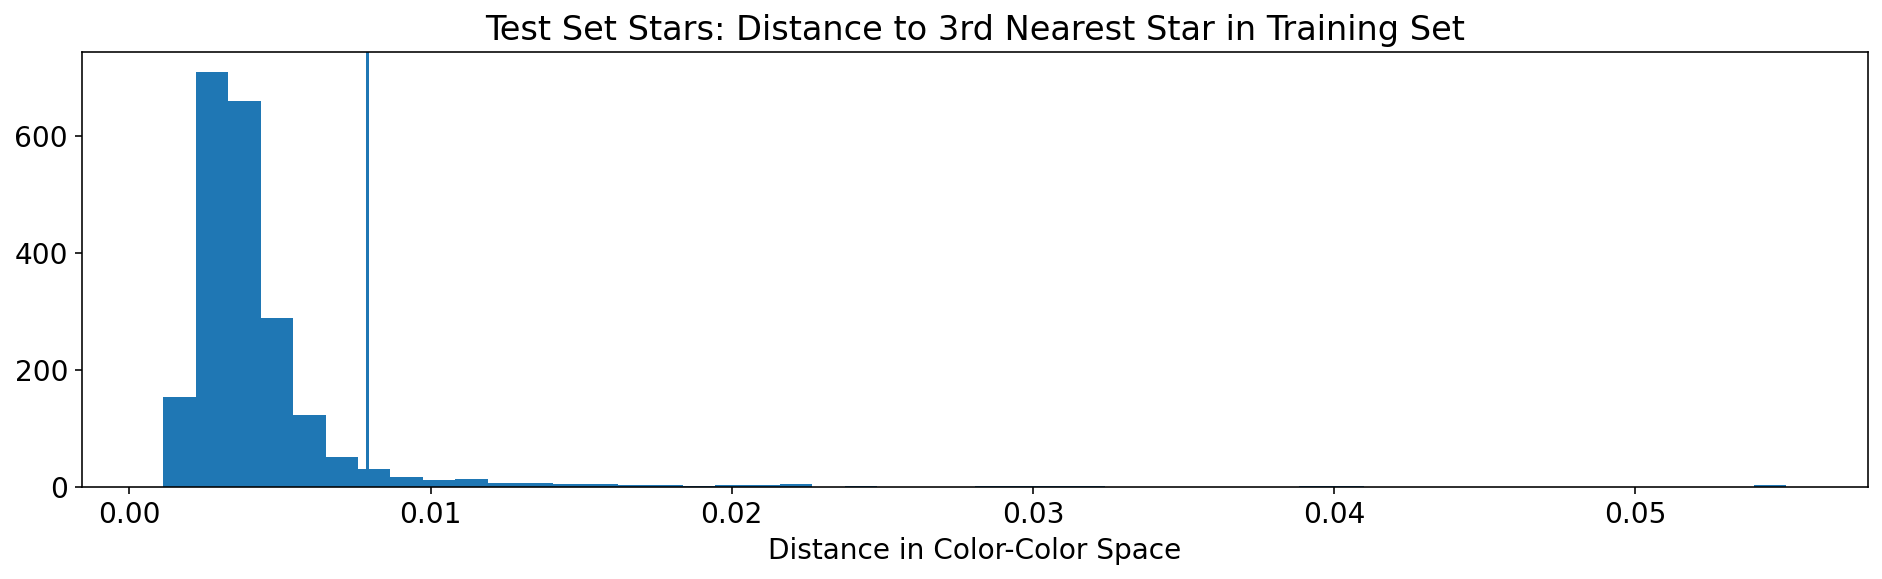

In [152]:
from sklearn.neighbors import NearestNeighbors
# Pull 3 nearest neighbors. Currently using "brute" algorithm given small size of dataset, but can adjust to other options
nbrs = NearestNeighbors(n_neighbors=3, algorithm='brute').fit(X_train[['decam_(g-r)','decam_(r-z)','decam_(r-i)']])
distances_cc, _ = nbrs.kneighbors(X_test[['decam_(g-r)','decam_(r-z)','decam_(r-i)']])
X_test['nn_colorcolor'] = distances_cc[:,2] #Distance in color-color of the 3rd nearest neighbor
nn_cutoff_cc = np.percentile(distances_cc[:,2],95)
# nbrs = NearestNeighbors(n_neighbors=3, algorithm='auto').fit(X_train[['wavg_mag_psf_r_dered']])
# distances_rmag, _ = nbrs.kneighbors(X_test[['wavg_mag_psf_r_dered']])
# X_test['nn_rmag'] = distances_rmag[:,0]
# nn_cutoff_rmag = np.percentile(distances_rmag[:,2],95)

# Now remove all rows that don't pass Nearest Neighbor check
nn_mask = X_test['nn_colorcolor'] <= nn_cutoff_cc

# Evaluate RMSE of new dataset
error = model.evaluate(X_test_transformed[nn_mask][model_columns], y_test[nn_mask]['feh50'], verbose=0) # Evaluate model performance on test
rmse = np.sqrt(error)
print('MSE: %.3f, RMSE: %.3f' % (error, rmse))

#Visual
fig, ax = plt.subplots(1, 1, figsize=(16,4))
plt.hist(X_test['nn_colorcolor'], bins=50)
plt.axvline(nn_cutoff_cc)
plt.xlabel("Distance in Color-Color Space")
plt.title("Test Set Stars: Distance to 3rd Nearest Star in Training Set")
plt.show()

## Color-Color Plot
For visual purposes only. Delete or comment out if unwanted

Notice, in the predicted data (right side), that the outlier stars are helpfully cut out by the NN cut. However, the extrema of metallicities is reduced at both ends (which is unsurprising, but makes accurately predicting metal-poor stars more difficult)

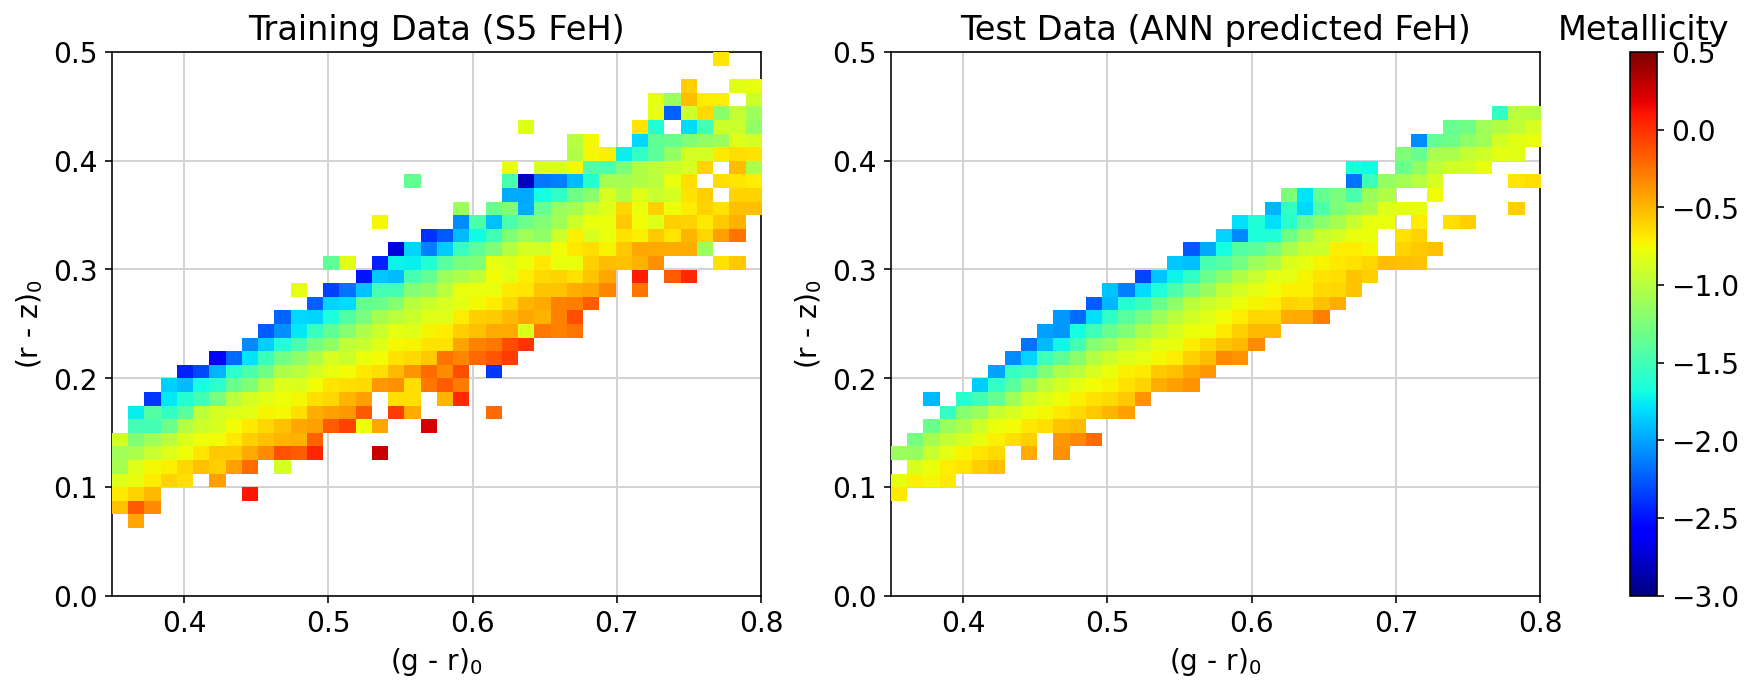

In [153]:
plt.rcParams.update({'font.size': 14})
def mean_metallicity_across_color_space(first_color, second_color, metallicity, boundaries, length, min_stars):
    twoD_histogram, first_color_ticks, second_color_ticks = np.histogram2d(first_color, second_color, bins = length, range = boundaries)
    FeH50_arr = []
    count = 0
    for j in np.arange(length): #Y axis colorspace
        for i in np.arange(length): #X axis colorsapce
            index = np.where(((first_color < first_color_ticks[i+1]) & (first_color >= first_color_ticks[i])) & ((second_color < second_color_ticks[j+1]) & (second_color >= second_color_ticks[j])))[0]
            if np.size(index) >= min_stars:
                m = np.mean(metallicity[index])
                count += np.size(metallicity[index])
            else:
                m = np.NaN
            FeH50_arr.append(m)
    FeH50_arr = np.array(FeH50_arr).reshape(length,length)
    return FeH50_arr, first_color_ticks, second_color_ticks, count

bound1 = [0.35, 0.8, 0 , 0.5]
bound2 = [0.35 , 0.8, 0 , 0.5]

# Change parameters below to adjust what data is being processed into a color-color plot
colorspace_metallicity1, x1, y1, c1 = mean_metallicity_across_color_space(np.array(X_train['decam_(g-r)']),np.array(X_train['decam_(r-z)']),
                                                                          np.array(y_train['feh50']), [[bound1[0],bound1[1]],[bound1[2],bound1[3]]], 40, min_stars=1)
colorspace_metallicity2, x2, y2, c2 = mean_metallicity_across_color_space(np.array(X_test[nn_mask]['decam_(g-r)']),np.array(X_test[nn_mask]['decam_(r-z)']),
                                                                          np.array(y_test[nn_mask]['pred_feh']), [[bound1[0],bound1[1]],[bound1[2],bound1[3]]], 40, min_stars=1)


fig, ax = plt.subplots(1, 2, figsize=(16,5))
im1 = ax[0].imshow(colorspace_metallicity1, cmap='jet', extent = bound1, origin='lower', aspect='auto',
                    vmin=-3,vmax=0.5, zorder=3)
im2 = ax[1].imshow(colorspace_metallicity2, cmap='jet', extent = bound2, origin='lower', aspect='auto',
                    vmin=-3,vmax=0.5, zorder=3)
ax[0].set_xlabel("(g - r)$_0$")
ax[0].set_ylabel("(r - z)$_0$")
ax[0].set_ylim(0, 0.5)
ax[1].set_ylim(0, 0.5)
ax[0].set_xlim(0.35, 0.8)
ax[1].set_xlim(0.35, 0.8)

ax[1].set_xlabel("(g - r)$_0$")
ax[1].set_ylabel("(r - z)$_0$")
ax[0].set_title("Training Data (S5 FeH)")
ax[1].set_title("Test Data (ANN predicted FeH)")
cbar = plt.colorbar(im1, ax=ax)
cbar.ax.set_title('Metallicity')
ax[0].grid(color='lightgrey', linestyle='-', linewidth=1)
ax[1].grid(color='lightgrey', linestyle='-', linewidth=1)
plt.show()

# Globular Cluster
Very similar to processing of original training data

8728  >  3992


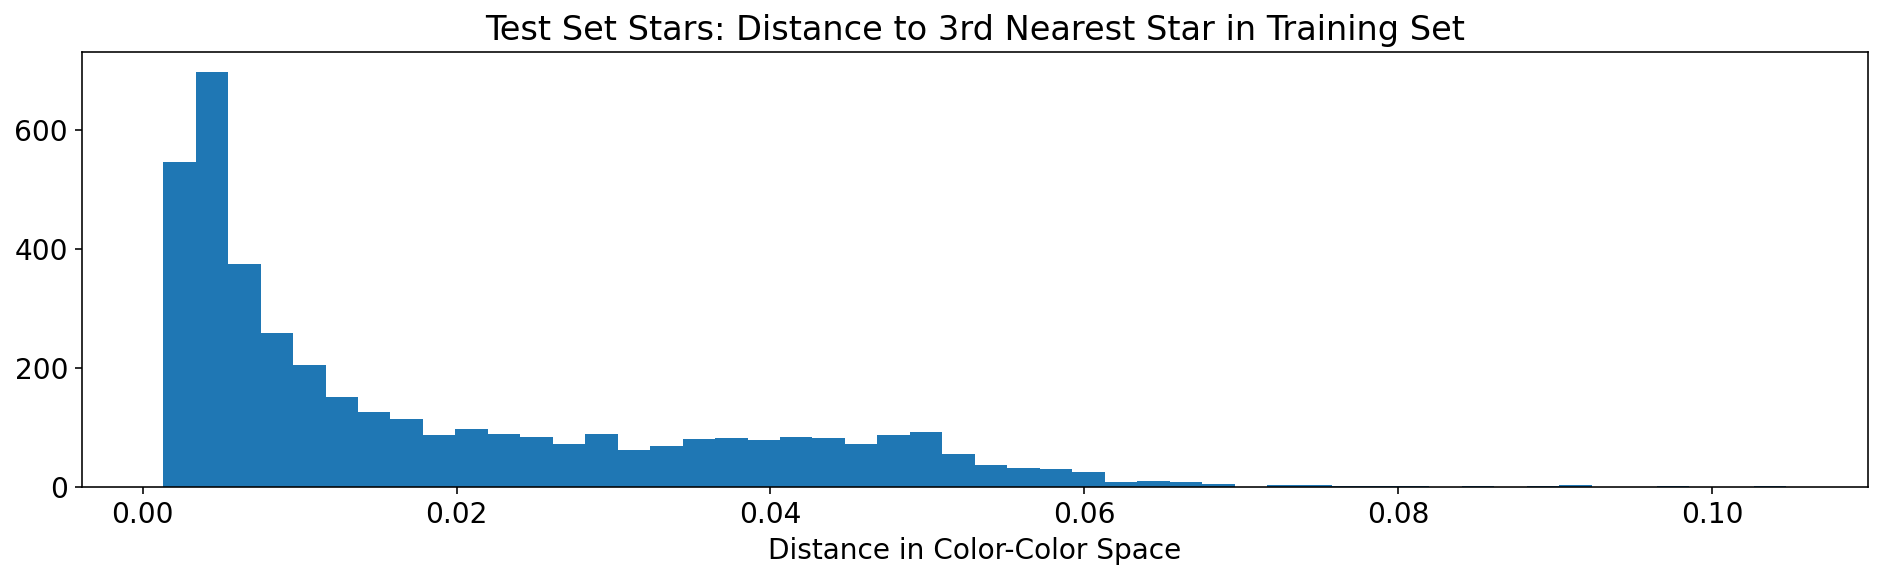

3992  >  1670


In [154]:
# Read data similar to training set
dat = Table.read(r"Data/GC_GaiaEDR3_DesDR2.fits", format='fits')
df_globclusters = dat.to_pandas()
# Then process and apply cuts (same as above, except no spectroscopy-based cuts)
df_globclusters['decam_(g-r)'] = df_globclusters["wavg_mag_psf_g_dered"] - df_globclusters["wavg_mag_psf_r_dered"]
df_globclusters['decam_(r-z)'] = df_globclusters["wavg_mag_psf_r_dered"] - df_globclusters["wavg_mag_psf_z_dered"]
df_globclusters['decam_(r-i)'] = df_globclusters["wavg_mag_psf_r_dered"] - df_globclusters["wavg_mag_psf_i_dered"]
df_globclusters['decam_(r-y)'] = df_globclusters["wavg_mag_psf_r_dered"] - df_globclusters["wavg_mag_psf_y_dered"]
### Photometry cuts
g_minus_r_mask = df_globclusters.index[df_globclusters['decam_(g-r)'].between(0.30,0.8)].tolist()
r_minus_z_mask= df_globclusters.index[df_globclusters['decam_(r-z)'].between(0,0.5)].tolist()
r_minus_i_mask= df_globclusters.index[df_globclusters['decam_(r-i)'].between(0.0,0.3)].tolist()
r_mask= df_globclusters.index[df_globclusters['wavg_mag_psf_r_dered'].between(14,25)].tolist()
g_mask= df_globclusters.index[df_globclusters['wavg_mag_psf_g_dered'].between(14,25)].tolist()
i_mask= df_globclusters.index[df_globclusters['wavg_mag_psf_i_dered'].between(14,25)].tolist()
z_mask= df_globclusters.index[df_globclusters['wavg_mag_psf_z_dered'].between(14,25)].tolist()
### Gaia cuts
gaia_g_mask = df_globclusters.index[df_globclusters['phot_g_mean_mag'].between(13,25)].tolist()
gaia_bp_mask = df_globclusters.index[df_globclusters['phot_bp_mean_mag'].between(13,25)].tolist()
gaia_rp_mask = df_globclusters.index[df_globclusters['phot_rp_mean_mag'].between(13,25)].tolist()
gaia_parallax_mask = df_globclusters.index[df_globclusters['parallax'].between(-2,4)].tolist()
# For cut details see excel doc
total_mask = reduce(np.intersect1d, (g_minus_r_mask,r_minus_z_mask,r_minus_i_mask,r_mask,g_mask,i_mask,
                                     z_mask,gaia_g_mask, gaia_bp_mask, gaia_rp_mask,gaia_parallax_mask))
print(np.shape(df_globclusters)[0], ' > ', np.size(total_mask)) #print size of cut
pd.options.mode.chained_assignment = None  # default='warn'
df_globclusters = df_globclusters.loc[total_mask]
df_globclusters.shape

### Nearest Neighbor cut
nbrs = NearestNeighbors(n_neighbors=3, algorithm='brute').fit(X_train[['decam_(g-r)','decam_(r-z)','decam_(r-i)']])
distances_cc, _ = nbrs.kneighbors(df_globclusters[['decam_(g-r)','decam_(r-z)','decam_(r-i)']])
df_globclusters['nn_colorcolor'] = distances_cc[:,2]

fig, ax = plt.subplots(1, 1, figsize=(16,4))
plt.hist(df_globclusters['nn_colorcolor'], bins=50)
plt.xlabel("Distance in Color-Color Space")
plt.title("Test Set Stars: Distance to 3rd Nearest Star in Training Set")
plt.show()

globcluster_nn_mask = df_globclusters['nn_colorcolor'] <= nn_cutoff_cc
df_globclusters = df_globclusters[globcluster_nn_mask]
print(np.size(total_mask), ' > ', np.shape(df_globclusters)[0])

#predict Fe/H!
df_globclusters["pred_feh"] = model.predict(stdscal.transform(df_globclusters[model_columns]))

## Code for processing Gaia data
import getDust
df_globclusters['AG'], df_globclusters['Abp'], df_globclusters['Arp'] = getDust.getDust(df_globclusters['phot_g_mean_mag'], df_globclusters['phot_bp_mean_mag'], df_globclusters['phot_rp_mean_mag'], 0.86*df_globclusters['ebv'])
df_globclusters['phot_bp_mean_mag_dered'] = df_globclusters['phot_bp_mean_mag']  - df_globclusters['Abp']
df_globclusters['phot_rp_mean_mag_dered'] = df_globclusters['phot_rp_mean_mag']  - df_globclusters['Arp']
df_globclusters['phot_g_mean_mag_dered'] = df_globclusters['phot_g_mean_mag']  - df_globclusters['AG']
df_globclusters['decam_r0'] = df_globclusters['wavg_mag_psf_r_dered']

## Error
While RMSE accounts for systematic error, statistical error also exists. We calculated this using a Monte Carlo method. Some bins of r_mag error and corresponding predicted Fe/H error are provided below. The code simply converts rmag errors in the dataset to the corresponding Fe/H statistical error

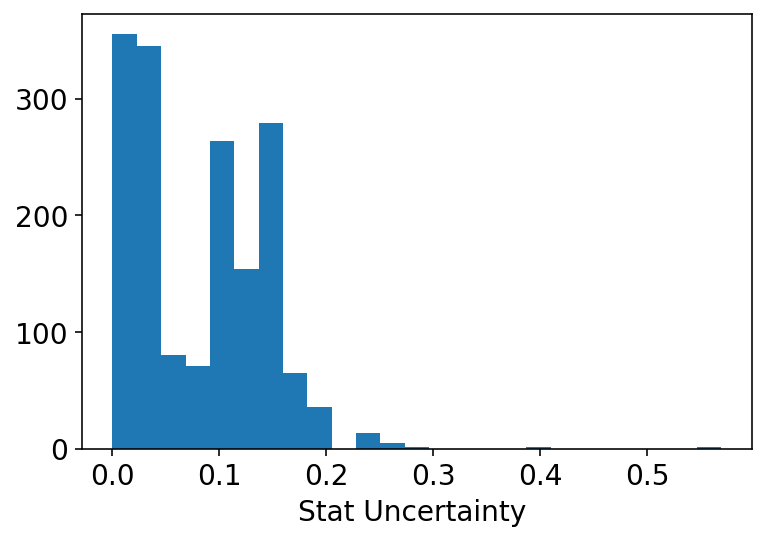

In [155]:
rerr_bins = np.array([0.0001,0.00011513953993264469,0.00013257113655901095,0.00015264179671752333,0.00017575106248547912,0.00020235896477251576,0.00023299518105153718,0.00026826957952797245,0.00030888435964774815,0.00035564803062231287,0.00040949150623804275,0.00047148663634573947,0.0005428675439323859,0.0006250551925273976,0.0007196856730011522,0.0008286427728546842,0.0009540954763499944,0.0010985411419875584,0.0012648552168552957,0.0014563484775012444,0.0016768329368110084,0.0019306977288832496,0.0022229964825261957,0.002559547922699536,0.0029470517025518097,0.00339322177189533,0.003906939937054617,0.004498432668969444,0.005179474679231213,0.005963623316594642,0.006866488450042998,0.0079060432109077,0.009102981779915217,0.010481131341546853,0.012067926406393288,0.013894954943731374,0.015998587196060572,0.018420699693267165,0.021209508879201904,0.024420530945486497,0.028117686979742307,0.032374575428176434,0.03727593720314938,0.04291934260128778,0.04941713361323833,0.05689866029018293,0.0655128556859551,0.07543120063354615,0.08685113737513521,0.1])
feh_stat_err_bins = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005948110544760538,0.012872746368037933,0.01582550763572064,0.02048350064637064,0.02139167827502597,0.0279574153291726,0.031742536637982696,0.03752338611281894,0.04481973128164734,0.05113426288006976,0.0598156200237789,0.07057392400906257,0.08120000787297516,0.09284218789163823,0.1065711595730274,0.12213441933474693,0.13911560194691935,0.15932973195155653,0.17985569440125385,0.20260758848467106,0.22923161759646876,0.2595662726460605,0.2907287225084855,0.3249514284668014,0.36230217770153994,0.40206187767421897,0.4430405692572933,0.4850945926510134,0.5267129927243528,0.5690682282679339,0.61181005185697,0.6509625844251301,0.6873782085862173,0.7219313315173344,0.7565365726851158,0.7863145906331463,0.8131868237098472,0.8378677380812384,0.8594661948173874,0.8803549902757023])
error_index = np.digitize(df_globclusters['wavg_magerr_psf_r'], bins=rerr_bins) - 1 #np.digitize generates the corresponding bin index number for each input (-1 because it goes to the next-nearest, i.e. starts at 1)
df_globclusters['feh_stat_error'] = feh_stat_err_bins[error_index]

plt.hist(df_globclusters['feh_stat_error'], bins=25)
plt.xlabel("Stat Uncertainty ")
plt.show()

df_globclusters = df_globclusters[df_globclusters['feh_stat_error'] < 0.2] #Cut some extreme error outliers out

## Literature Comparison
The code below comapres the predicted metallicity of 5 GCs in DES to a variety of literature sources. The details here (lit sources) aren't particularly important, but it serves as a good demonstration of how to analyze and display some data

In [156]:
GC_Names = df_globclusters["gcname"].unique() #Create a list of all Globular Cluster names from the dataset
# Here we define 5 GCs of note and various metallicities available in thte literature
GC_Names_minussmall = [b'NGC_1261', b'NGC_288',
       b'NGC_1904_M_79', b'NGC_7089_M_2', b'NGC_1851']
Marin_Franch = np.array([-1.32,-1.40,np.nan,-1.61,-1.23])
de_Angeli = np.array([np.nan,np.nan,-1.37,np.nan,np.nan])
Dotter = np.array([-1.35,-1.40,np.nan,-1.60,np.nan])
VandenBurg = np.array([-1.27,-1.32,np.nan,-1.66,-1.18])
UVES = np.array([-1.28,-1.305,-1.579,np.nan,-1.18])
GIRAFFE = np.array([-1.35,-1.219,-1.544,np.nan,-1.16])
misc = np.array([np.nan,-1.38,-1.69,np.nan,np.nan])
Harris_minus_small = np.array([-1.27,-1.32,-1.6,-1.65,-1.18])
Pancino = np.array([np.NaN, np.NaN, -1.51, -1.47, -1.07]) # Gaia-ESO Survey (2017)
Meszaros_minus_small = np.array([np.nan,-1.184,-1.468,-1.402,-1.033])
lit_names = ["Marin Franch","de Angeli","Dotter","VandenBurg","UVES","GIRAFFE","misc","Harris","Pancino"]

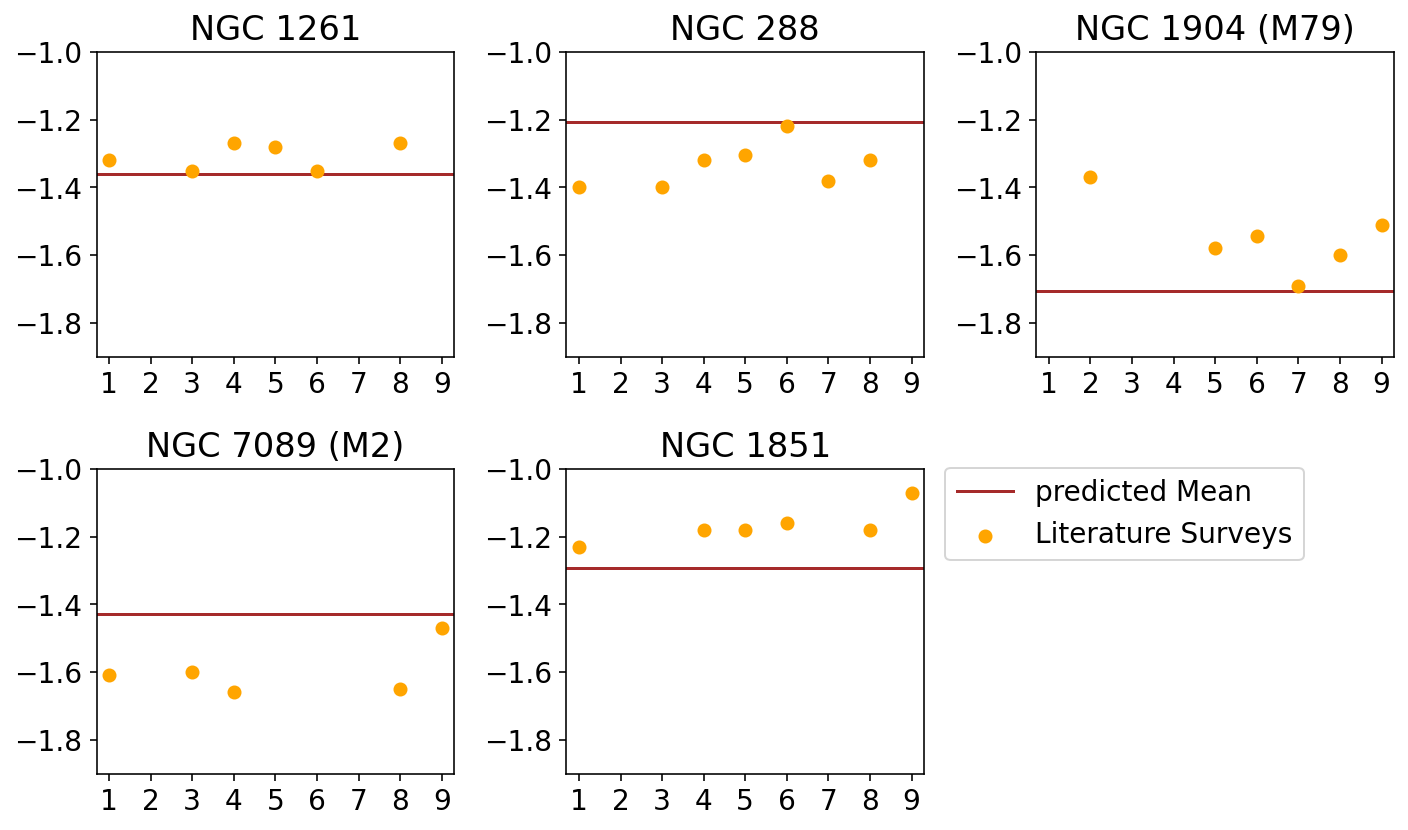

In [157]:
from matplotlib.patches import Rectangle
co = 0
a = 1
gcs = 5
surveys = 9
fig = plt.figure(figsize=(10,6))
lit_diff = np.zeros(surveys*gcs).reshape(gcs,surveys)
cutoff = [20, 19, 19.5, 19.3, 19.7] #Visually selected line in r_mag that is the RGB vs MS cutoff (selected using CMD)
cutoff_bs = np.array([[[0.3,19],[0.7,16]],[[0.3,18.5],[0.47,18]],[[0.3,18],[0.4,18]],
          [[0.39,18.5],[0.5,17]],[[0.3,18.8],[0.6,16.6]]]) #Again visually selected cutoff for blue stragglers
GC_name_str = ["NGC 1261", "NGC 288", "NGC 1904 (M79)", "NGC 7089 (M2)", "NGC 1851"]

for GC_name in GC_Names_minussmall:
    ax = fig.add_subplot(2, 3, a)
    gc = df_globclusters[df_globclusters['gcname']== GC_name] #Select each GC by name
    # Cutoff blue straggler stars (using visually-derived equation from CMD)
    coeff = np.polyfit([cutoff_bs[co,0,0],cutoff_bs[co,1,0]],[cutoff_bs[co,0,1],cutoff_bs[co,1,1]],1)
    bs_func = np.poly1d(coeff)
    gc = gc[~((gc['decam_(g-r)'] < cutoff_bs[co,1,0]) & (gc['decam_(g-r)'] > cutoff_bs[co,0,0])
                        & (gc['wavg_mag_psf_g_dered'] < bs_func(gc['decam_(g-r)'])))]
    #gc = gc[abs(gc['pred_feh_debias']-np.mean(gc['pred_feh_debias'])) < (2.5*np.std(gc['pred_feh_debias']))]
    gc_giants = gc[gc['wavg_mag_psf_r_dered'] < cutoff[co]]
    gc_ms = gc[gc['wavg_mag_psf_r_dered'] > cutoff[co]]
    diff = np.mean(gc_giants['pred_feh']) - np.array([Marin_Franch[co],de_Angeli[co],Dotter[co],VandenBurg[co],
                                                   UVES[co],GIRAFFE[co],misc[co],Harris_minus_small[co],Pancino[co]])
    
    #ax.axhline(np.mean(gc_giants['pred_feh']), color='red', label="predicted RGB Mean")
    ax.axhline(np.mean(gc['pred_feh']), color='brown', label="predicted Mean")

    ax.scatter(np.arange(1,surveys+1),[Marin_Franch[co],de_Angeli[co],Dotter[co],VandenBurg[co],
                                                   UVES[co],GIRAFFE[co],misc[co],Harris_minus_small[co],Pancino[co]],color='orange',
               zorder=3, label='Literature Surveys')
    ax.set_xticks(np.arange(1,surveys+1))
    #ax.set_xticklabels(lit_names)
    ax.set_title(GC_name_str[co])
    ax.set_ylim([-1.9,-1])
    ax.set_xlim([0.7,9.3])
    lit_diff[co] = diff
    handles, labels = ax.get_legend_handles_labels()
    #fig.legend(handles, labels, loc='lower right')
    co += 1
    a += 1
plt.tight_layout()
plt.legend(bbox_to_anchor=(2.1, 1.05))
plt.show()